## 1. Tree-Based Methods

Import packages

In [200]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

### (a) Download the APS Failure data

In [202]:
df_train = pd.read_csv('../data/aps_failure_training_set.csv',skiprows=20)
df_test = pd.read_csv('../data/aps_failure_test_set.csv',skiprows=20)
df_train

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002,na,664,186,0,0,0,0,0,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,neg,2286,na,2130706538,224,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,neg,112,0,2130706432,18,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,neg,80292,na,2130706432,494,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


### (b) Data Preparation

#### (i) Research what types of techniques are usually used

Data Imputation techniques:<br>
1. Basic Mean/Median Imputation: Replace missing values with the mean or median value of the column.<br>
2. K-Nearest Neighbors (KNN) Imputation: Fill missing values using values from similar neighbors.<br>
3. Time-Series Specific - Forward Fill and Backward Fill<br>
4. MICE (Multiple Imputation): Run multiple imputations to account for uncertainty.<br>
5. Zero/Constant Imputation: Replace missing values with 0 or a fixed value 

In [206]:
df_train = df_train.replace({'neg': 0, 'pos': 1, 'na':np.nan})
df_test = df_test.replace({'neg': 0, 'pos': 1, 'na':np.nan})
df_train

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,NaN,0,NaN,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,NaN,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,0,60874,NaN,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,153002,NaN,664,186,0,0,0,0,0,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,0,2286,NaN,2130706538,224,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,0,112,0,2130706432,18,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,0,80292,NaN,2130706432,494,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0


In [207]:
print("Training Data: ", df_train.shape)
print("Testing Data: ", df_test.shape)

Training Data:  (60000, 171)
Testing Data:  (16000, 171)


In [208]:
imputer = SimpleImputer(strategy='mean')
X_train_bef = df_train.drop('class', axis=1)
y_train = df_train['class']
X_test_bef = df_test.drop('class', axis=1)
y_test = df_test['class']

X_train = pd.DataFrame(imputer.fit_transform(X_train_bef), columns=X_train_bef.columns)
X_test = pd.DataFrame(imputer.transform(X_test_bef), columns=X_test_bef.columns)
X_train

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002.0,0.713189,6.640000e+02,186.000000,0.0,0.0,0.0,0.0,0.0,2564.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,2286.0,0.713189,2.130707e+09,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,112.0,0.000000,2.130706e+09,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,80292.0,0.713189,2.130706e+09,494.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


#### (ii) Calculate the coefficient of variation

In [210]:
df_features = pd.concat([X_train,X_test])
cv = (df_features.std() / df_features.mean())
print(cv)

aa_000      4.328608
ab_000      2.207351
ac_000      2.167798
ad_000    193.955307
ae_000     22.282263
             ...    
ee_007      4.885304
ee_008      3.335353
ee_009      5.754213
ef_000     47.781107
eg_000     45.711130
Length: 170, dtype: float64


#### (iii) Plot a correlation matrix

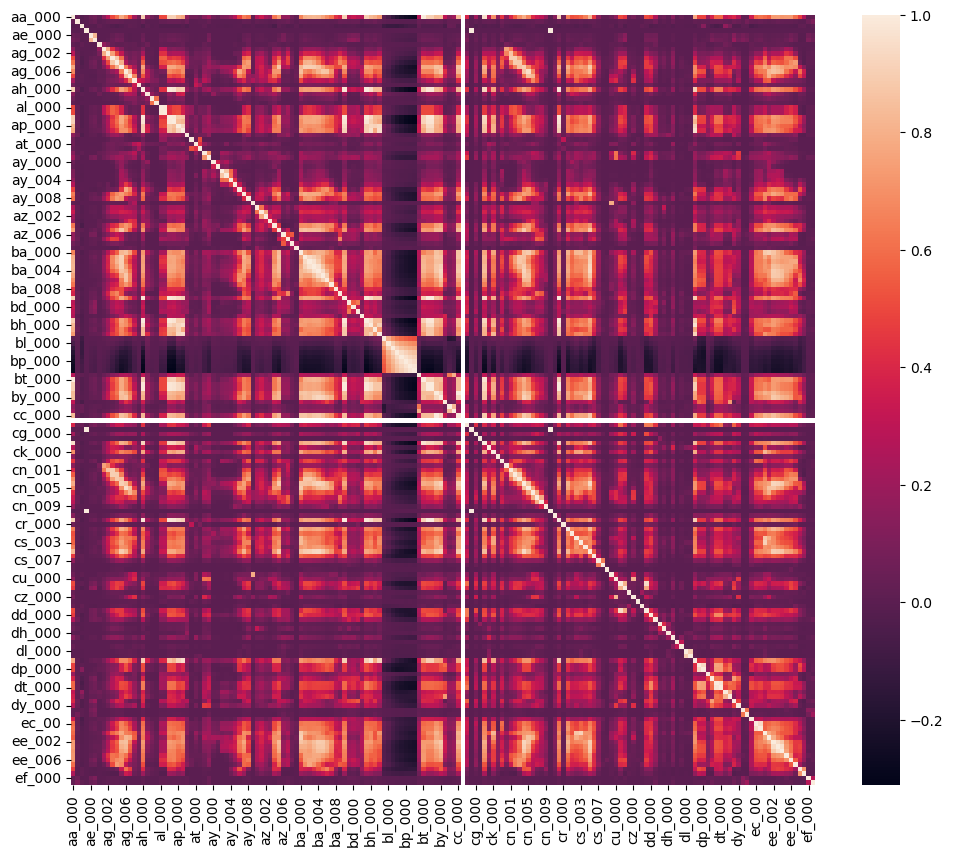

In [212]:
plt.figure(figsize=(12,10))
sns.heatmap(X_train.corr())
plt.show()

#### (iv) Make scatter plots and box plots

In [214]:
cv_sorted = cv.sort_values(ascending=False)
n_features = int(math.sqrt(170))
top_features = cv_sorted.index[:n_features]
top_features

Index(['cf_000', 'co_000', 'ad_000', 'cs_009', 'dj_000', 'df_000', 'as_000',
       'dh_000', 'ag_000', 'au_000', 'ak_000', 'az_009', 'ay_009'],
      dtype='object')

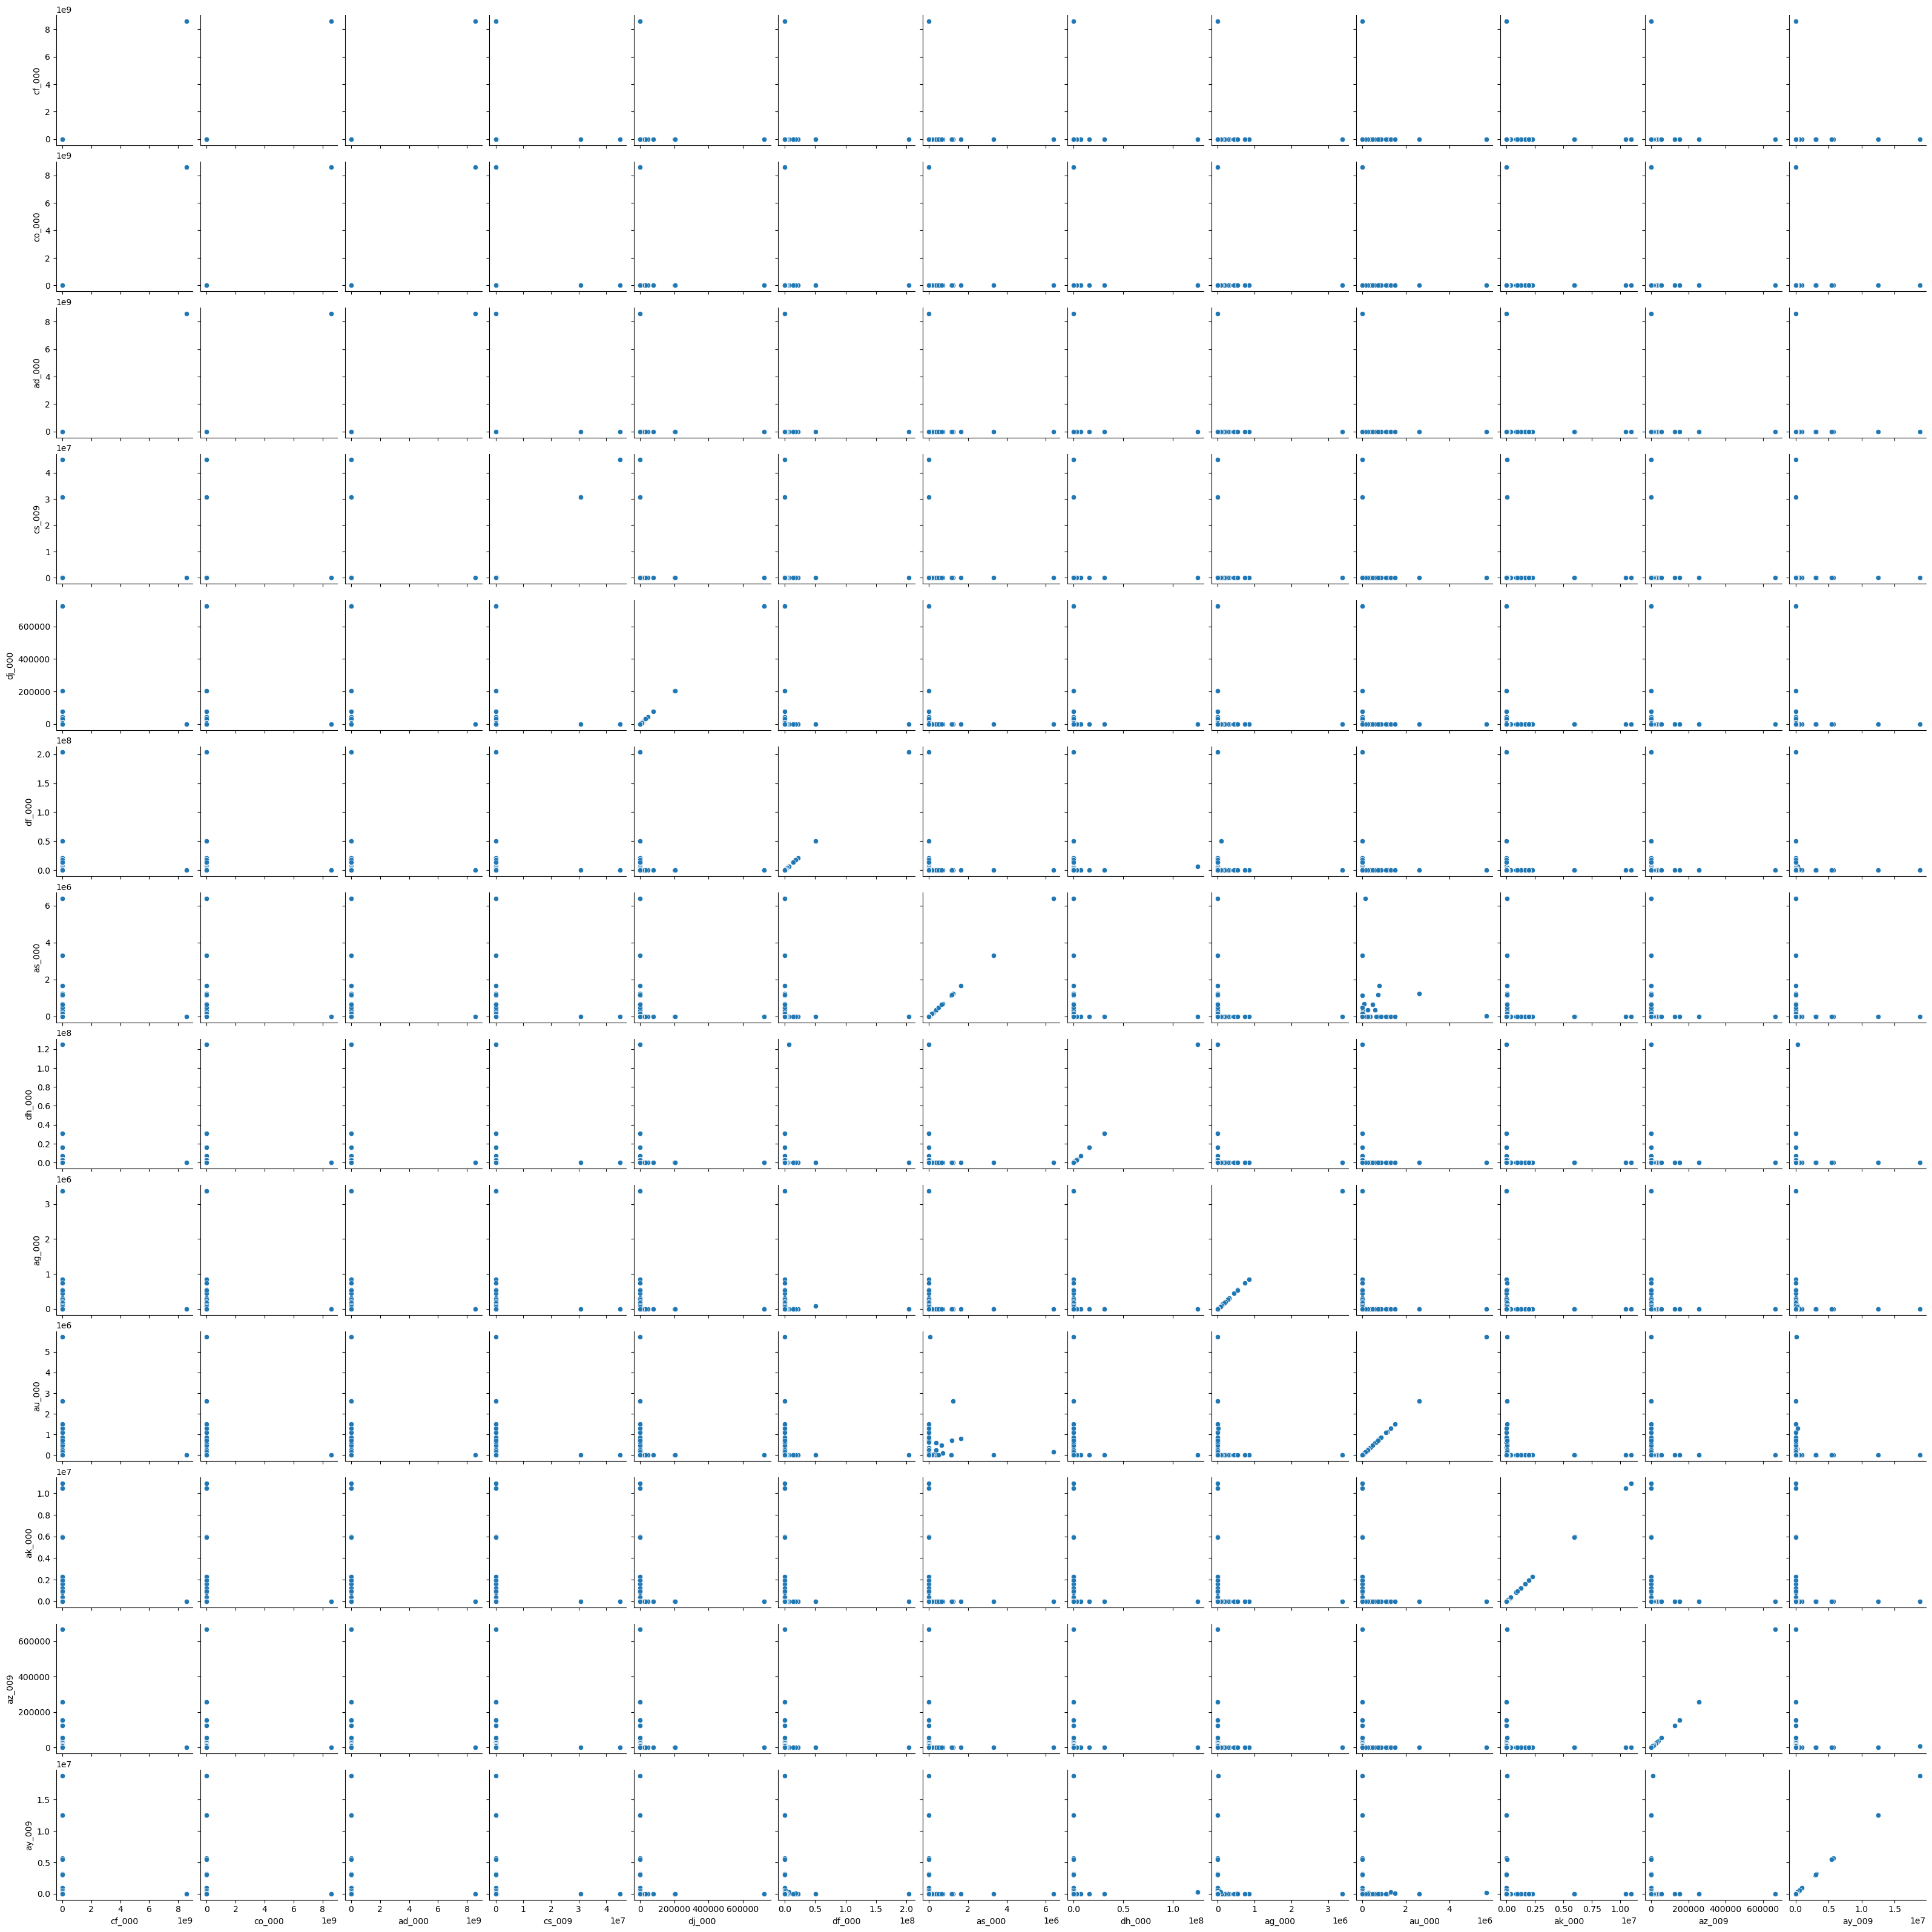

In [215]:
sns.pairplot(df_features[list(top_features)], diag_kind=None)

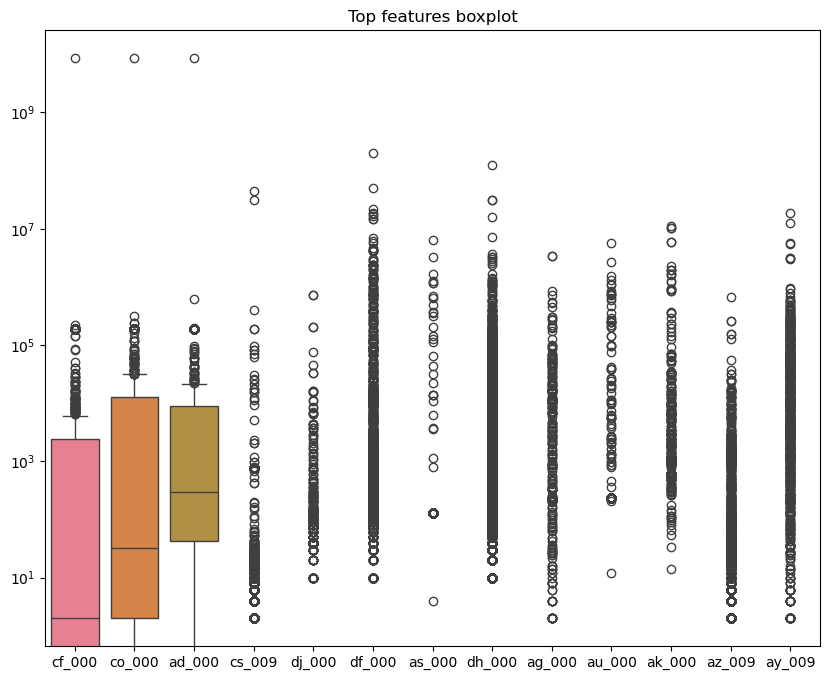

In [216]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df_features[list(top_features)]).set(yscale = "log")
plt.title("Top features boxplot")
plt.show()

It is difficult to draw conclusions from just the scatter plot

#### (v) Is this data set imbalanced?

In [219]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
ratio = pos / neg
print(f"negative values = {neg}, positive values = {pos}, ratio = {ratio}")

negative values = 59000, positive values = 1000, ratio = 0.01694915254237288


The data is highly imbalanced

### (c) Train a random forest

In [222]:
model_rf = RandomForestClassifier(random_state=42, oob_score=True)
model_rf.fit(X_train, y_train)

y_train_pred = model_rf.predict(X_train)
y_test_pred = model_rf.predict(X_test)
y_train_proba = model_rf.predict_proba(X_train)[:, 1]
y_test_proba = model_rf.predict_proba(X_test)[:, 1]

def evaluate_model(y_true, y_pred, y_proba):
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):}")
    print(f"AUC: {roc_auc_score(y_true, y_proba):}")
    
    fpr, tpr, x = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.show()

Training Set
Confusion Matrix:
[[59000     0]
 [    1   999]]
Accuracy: 0.9999833333333333
AUC: 1.0


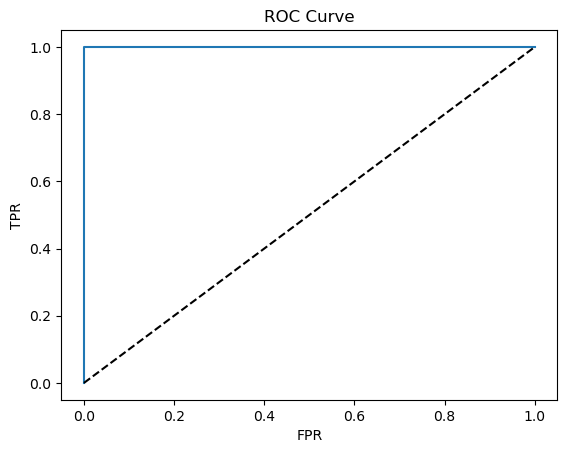

In [223]:
print("Training Set")
evaluate_model(y_train, y_train_pred, y_train_proba)

Test Set
Confusion Matrix:
[[15609    16]
 [  107   268]]
Accuracy: 0.9923125
AUC: 0.9941632853333333


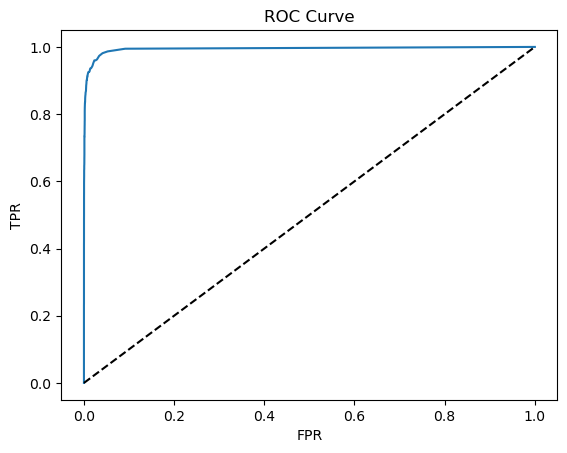

In [224]:
print("Test Set")
evaluate_model(y_test, y_test_pred, y_test_proba)

In [225]:
print(f"OOB Error: {1 - model_rf.oob_score_:}")
print(f"Test Error: {1 - accuracy_score(y_test, y_test_pred):}")

OOB Error: 0.00605
Test Error: 0.007687499999999958


References: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html <br>
https://stats.stackexchange.com/questions/188616/how-can-we-calculate-roc-auc-for-classification-algorithm-such-as-random-forest

### (d) Research class imbalance in random forest

Class Imbalance in Random Forest: <br>
1. class_weight='balanced' – Automatically adjusts weights to prioritize the minority class.
2. Undersampling – Randomly reduces majority class samples.
3. SMOTE – Generates synthetic minority class samples.
4. BalancedRandomForest – Built-in balanced subsampling for each tree.

In [229]:
model_rf_bal = RandomForestClassifier(random_state=42,class_weight='balanced', oob_score=True)
model_rf_bal.fit(X_train, y_train)

y_train_pred2 = model_rf_bal.predict(X_train)
y_test_pred2 = model_rf_bal.predict(X_test)
y_train_proba2 = model_rf_bal.predict_proba(X_train)[:, 1]
y_test_proba2 = model_rf_bal.predict_proba(X_test)[:, 1]

Compensation for class Imbalance:
Training Set
Confusion Matrix:
[[59000     0]
 [    1   999]]
Accuracy: 0.9999833333333333
AUC: 1.0


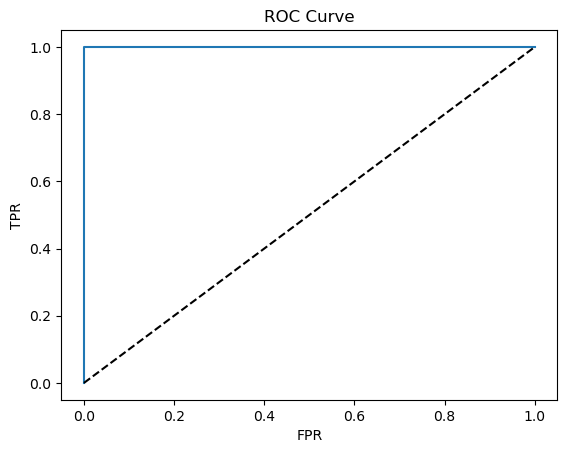

In [230]:
print("Compensation for class Imbalance:")
print("Training Set")
evaluate_model(y_train, y_train_pred2, y_train_proba2)

Test Set
Confusion Matrix:
[[15613    12]
 [  166   209]]
Accuracy: 0.988875
AUC: 0.9864612693333332


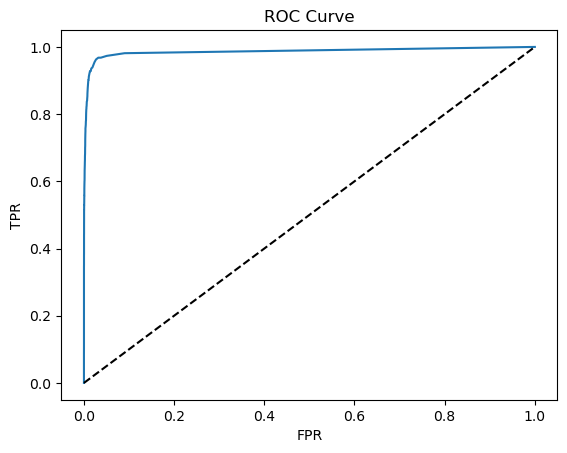

In [231]:
print("Test Set")
evaluate_model(y_test, y_test_pred2, y_test_proba2)

In [232]:
print(f"OOB Error: {1 - model_rf_bal.oob_score_:}")
print(f"Test Error: {1 - accuracy_score(y_test, y_test_pred2):}")

OOB Error: 0.007683333333333375
Test Error: 0.011125000000000052


Comparision: <br>
With class imbalance, the model performs better based on test error and oob estimate. Both models incline towards the negative class, classing significant amount of positive class as negative class

### (e) XGBoost and Model Trees

In [235]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {'reg_alpha': np.logspace(-5, 5, 10) }
model_xgb = XGBClassifier( objective='binary:logistic', booster='gbtree', random_state=42)

grid_search = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    cv=5,                        
    scoring='accuracy',           
    verbose=1)

grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['reg_alpha']
print(f"Best alpha (L1 penalty): {best_alpha}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best alpha (L1 penalty): 0.021544346900318846


In [236]:
best_model_xgb = XGBClassifier(
    objective='binary:logistic',
    reg_alpha=best_alpha,
    n_estimators=100,
    random_state=42
)

best_model_xgb.fit(X_train_scaled, y_train)

y_train_pred_xgb = best_model_xgb.predict(X_train_scaled)
y_test_pred_xgb = best_model_xgb.predict(X_test_scaled)
y_train_proba_xgb = best_model_xgb.predict_proba(X_train_scaled)[:, 1]
y_test_proba_xgb = best_model_xgb.predict_proba(X_test_scaled)[:, 1]

Training set
Confusion Matrix:
[[59000     0]
 [    1   999]]
Accuracy: 0.9999833333333333
AUC: 0.9999998305084745


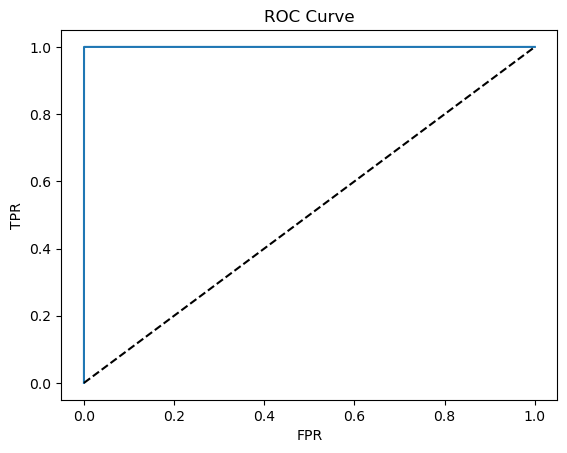

In [237]:
print("Training set")
evaluate_model(y_train, y_train_pred_xgb, y_train_proba_xgb)

Test set
Confusion Matrix:
[[15599    26]
 [   94   281]]
Accuracy: 0.9925
AUC: 0.993653248


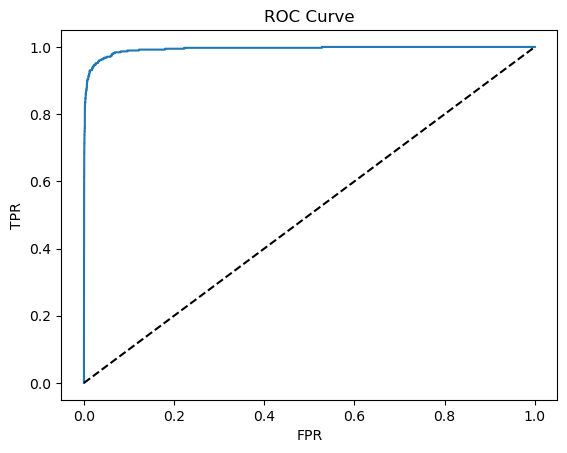

In [238]:
print("Test set")
evaluate_model(y_test, y_test_pred_xgb, y_test_proba_xgb)

In [239]:
cv_auc = grid_search.best_score_
test_auc = roc_auc_score(y_test, y_test_proba_xgb)
print(f"CV AUC: {cv_auc:.4f}, Test AUC: {test_auc:.4f}")

CV AUC: 0.9941, Test AUC: 0.9937


### (f) Use SMOTE to pre-process your data

Right way - apply smote to only training fold during Cross Validation

In [242]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),  
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        booster='gbtree',
        random_state=42, eval_metric='auc'
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid2 = {'xgb__reg_alpha': np.logspace(-4, 4, 10)}  

grid_search_smote = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid2,
    cv=cv,
    scoring='roc_auc',  
    verbose=2,          
    n_jobs=-1    
)

grid_search_smote.fit(X_train, y_train)
best_alpha_smote = grid_search_smote.best_params_['xgb__reg_alpha']
print(f"\nBest alpha (L1 penalty): {best_alpha_smote}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..............................xgb__reg_alpha=0.0001; total time=   8.9s
[CV] END ................xgb__reg_alpha=0.005994842503189409; total time=  54.8s
[CV] END ..................xgb__reg_alpha=0.3593813663804626; total time=   8.4s
[CV] END ...................xgb__reg_alpha=2.782559402207126; total time=   9.0s
[CV] END ..................xgb__reg_alpha=166.81005372000558; total time=   5.8s
[CV] END ..................xgb__reg_alpha=1291.5496650148827; total time=   6.7s
[CV] END .............................xgb__reg_alpha=10000.0; total time=   2.9s

Best alpha (L1 penalty): 0.005994842503189409


In [243]:
best_model_xgb_smote = XGBClassifier(
        objective='binary:logistic',
        reg_alpha=best_alpha_smote,
        booster='gbtree',
        random_state=42, eval_metric='auc'
    )

best_model_xgb_smote.fit(X_train, y_train)

y_train_pred_xgb_smote = best_model_xgb_smote.predict(X_train)
y_test_pred_xgb_smote = best_model_xgb_smote.predict(X_test)
y_train_proba_xgb_smote = best_model_xgb_smote.predict_proba(X_train)[:, 1]
y_test_proba_xgb_smote = best_model_xgb_smote.predict_proba(X_test)[:, 1]

Training set
Confusion Matrix:
[[59000     0]
 [    1   999]]
Accuracy: 0.9999833333333333
AUC: 0.9999999830508475


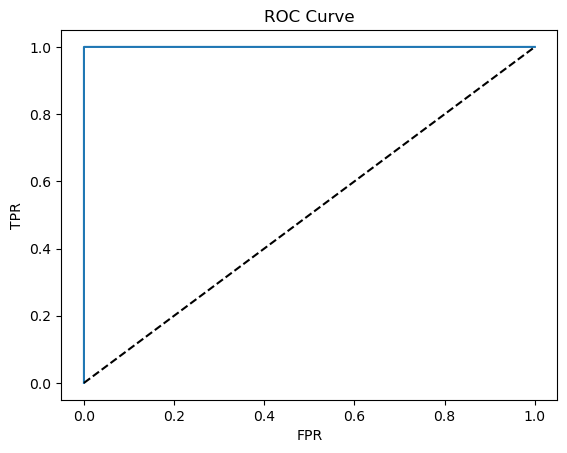

In [244]:
print("Training set")
evaluate_model(y_train, y_train_pred_xgb_smote, y_train_proba_xgb_smote)

Test set
Confusion Matrix:
[[15600    25]
 [   86   289]]
Accuracy: 0.9930625
AUC: 0.9938036053333333


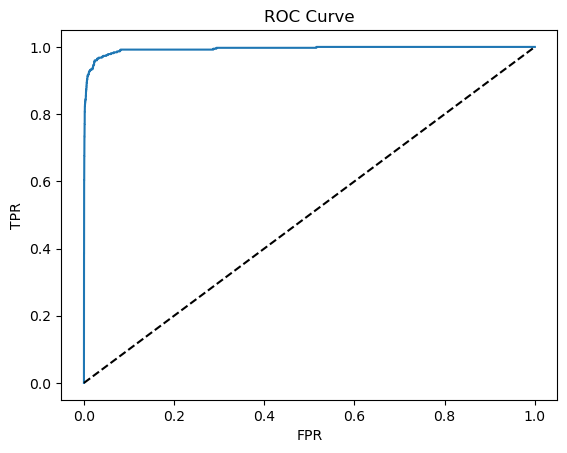

In [245]:
print("Test set")
evaluate_model(y_test, y_test_pred_xgb_smote, y_test_proba_xgb_smote)

In [246]:
cv_auc_smote = grid_search_smote.best_score_
test_auc_smote = roc_auc_score(y_test, y_test_proba_xgb_smote)
print(f"CV AUC: {cv_auc_smote:}, Test AUC: {test_auc_smote:}")

CV AUC: 0.9877208474576271, Test AUC: 0.9938036053333333


Comparision: <br>
From the confusion matrix of 1(d), uncompensated case 1(e) and SMOTE 1(f) - we can see that SMOTE gives comparatively less False Negatives for the Positive class. SMOTE performs better.

References: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html  <br>
https://vch98.medium.com/preventing-data-leakage-standardscaler-and-smote-e7416c63259c